In [11]:
#EXPERIMENT FROM 19st AUGUST
L = 864/10**6
sd1=350
Long = 3850
border_start = 4
border_stop = 70
f_name = ["/home/meriff/Python_projects/Experiment_graphene/Air.txt",
        "/home/meriff/Python_projects/Experiment_graphene/Substrate.txt",
        "/home/meriff/Python_projects/Experiment_graphene/Graphene.txt"]

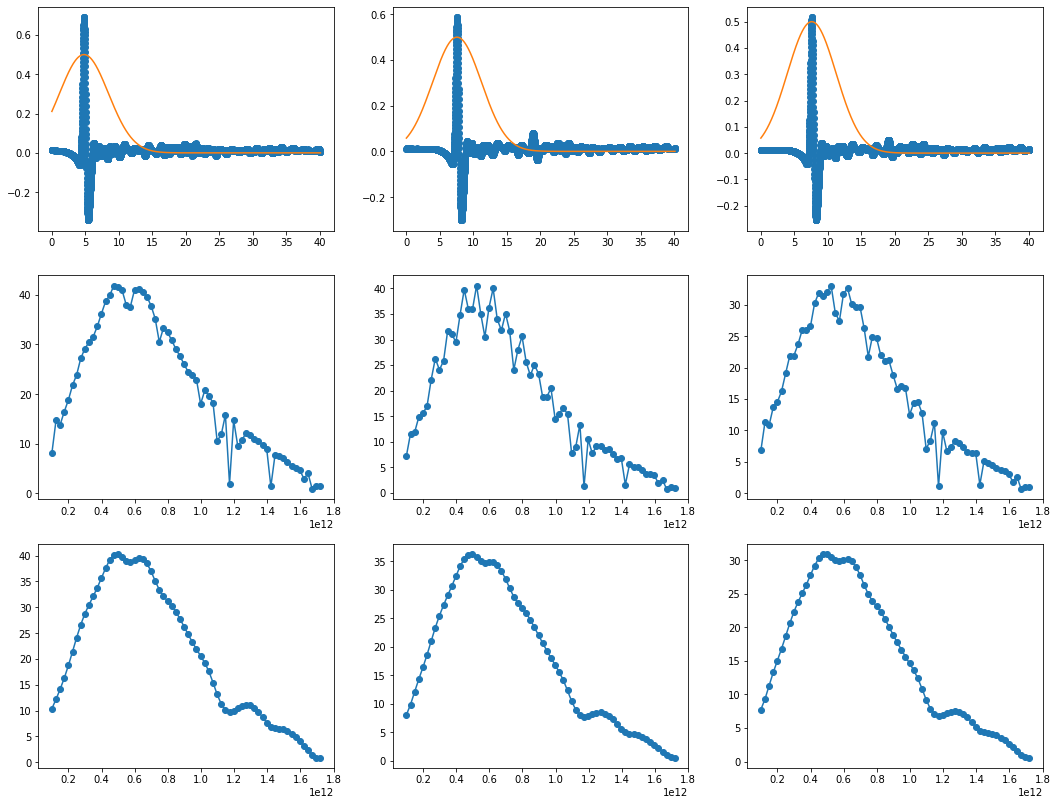

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
import math
from IPython.display import clear_output
from scipy.signal import butter
from scipy.signal import sosfilt

def read_info(f_name):
    handle = open(f_name, "r")
    data = []
    for line in handle:
        data.append([float(x) for x in line.split()])
    handle.close()
    timer_f=[]; signal_f=[]; N=len(data)
    for i in range (0,Long):
        timer_f.append(data[i][0])
        signal_f.append(data[i][1])
    return timer_f, signal_f,N

def move_to_zero(signal,N,count):
    average = 0
    for i in range (0,count):
        average = average + signal[i]
    average = average/count
    for i in range (0,N):
        signal[i] = signal[i] - average
    return signal

Sequence = np.arange(0,Long,1)

def gauss_filter(signal,mid,sd):
    for i in range (0,data_number):
        signal_gauss[i] = signal[i]*np.exp(-np.power((Sequence-mid[i]),2)/(2*sd[i]**2))
    return(signal_gauss)

data_number = len(f_name)
timer=np.zeros(Long)
signal=np.zeros((data_number,Long))
signal_gauss=np.zeros((data_number,Long))
limit=[30,70,70]         #15 is equal to 1 ps of time
sd=[sd1,sd1,sd1]
length_s=np.zeros(data_number)

for i in range (0,data_number):
    timer,signal[i],N = read_info(f_name[i])
    length_s[i] = N
    #signal[i] = move_to_zero(signal[i],N,limit[i])

mid=np.zeros(data_number)
for i in range (0,data_number):
    maxima = 0
    for j in range (0, Long):
        if (abs(signal[i,j])>maxima):
            mid[i] = j
            maxima = abs(signal[i,j])

signal_gauss = gauss_filter(signal,mid,sd)

dT = (timer[1] - timer[0])/10**12
frequency = np.fft.fftfreq(Long, dT)

signal_w=np.fft.fft(signal,axis=1)            #here fft is done
signal_w_gauss=np.fft.fft(signal_gauss,axis=1)

plt.rcParams['figure.figsize'] = [18,14]
fig,a=plt.subplots(3, data_number)

for i in range(0,data_number):
    N = Long
    a[0][i].plot(timer[0:N], signal[i,0:N], 'o-')
    a[0][i].plot(timer[0:N], gauss_filter(np.ones((data_number,Long))/2,mid,sd)[i,0:N])
    a[1][i].plot(frequency[border_start:border_stop],np.abs(signal_w[i,border_start:border_stop]),'o-')
    a[2][i].plot(frequency[border_start:border_stop],np.abs(signal_w_gauss[i,border_start:border_stop]),'o-')

plt.show()

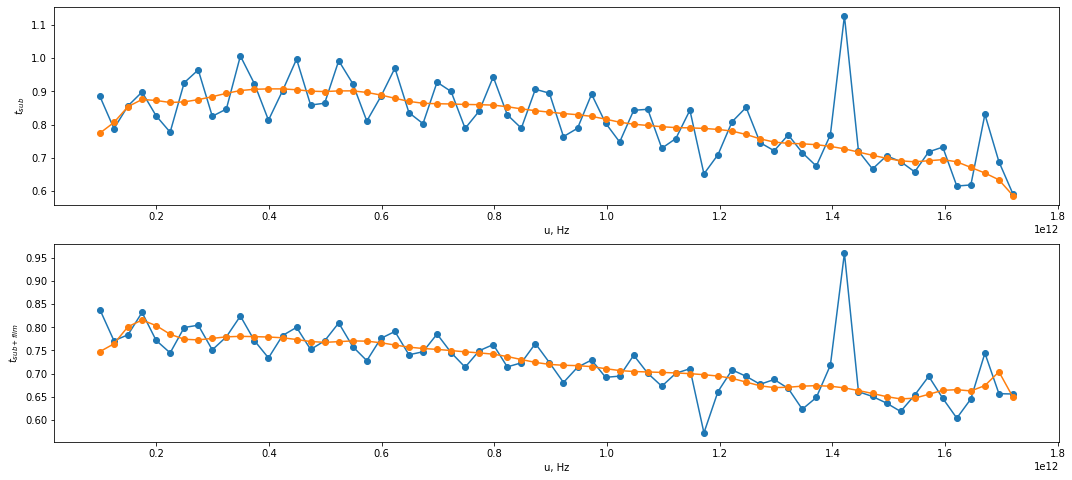

In [13]:
plt.rcParams['figure.figsize'] = [18,8]
titles = ["$t_{sub}$",
         "$t_{sub+flim}$"]
if data_number>2:
    fig,a=plt.subplots(data_number-1)
else:
    fig,a=plt.subplots()
for i in range (0,data_number-1):
    a[i].plot(frequency[border_start:border_stop],abs(signal_w[i+1,border_start:border_stop]/signal_w[0,border_start:border_stop]),'o-')
    a[i].plot(frequency[border_start:border_stop],abs(signal_w_gauss[i+1,border_start:border_stop]/signal_w_gauss[0,border_start:border_stop]),'o-')
    a[i].set_ylabel(titles[i])
    a[i].set_xlabel('u, Hz')

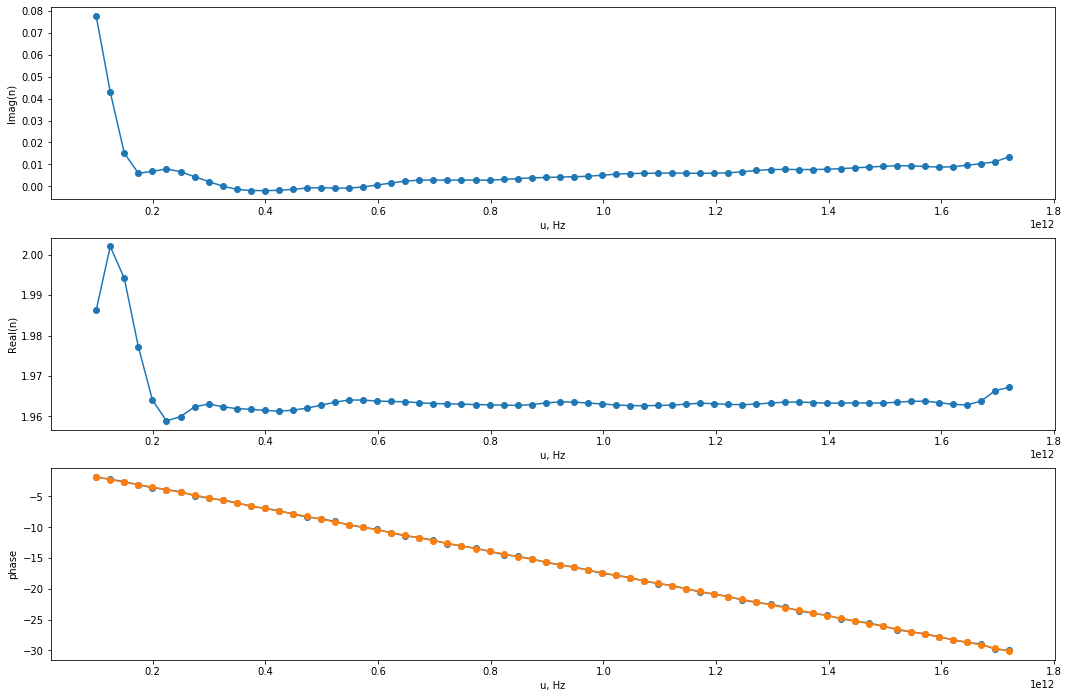

In [14]:
ph=np.zeros(border_stop); ph_gauss=np.zeros(border_stop)
H = np.zeros(border_stop, dtype = complex); H_gauss = np.zeros(border_stop, dtype = complex)
n_simple=np.zeros(border_stop)
k_simple=np.zeros(border_stop)
for i in range (border_start,border_stop):
    H[i] = signal_w[1,i]/signal_w[0,i];   H_gauss[i] = signal_w_gauss[1,i]/signal_w_gauss[0,i]
    ph[i] = cmath.phase(H[i]);   ph_gauss[i] = cmath.phase(H_gauss[i])
ph=np.unwrap(ph); ph_gauss = np.unwrap(ph_gauss)

wlc = np.zeros(border_stop)
for i in range (border_start,border_stop):
    wlc[i] = frequency[i]*2*math.pi*L/(3*10**8)
    
for i in range (border_start,border_stop):
    n_simple[i] = 1 - (ph_gauss[i])/wlc[i]
    k_simple[i] = math.log(4*n_simple[i]/((n_simple[i]+1)**2)/abs(H_gauss[i]))/wlc[i]
    
n=np.copy(n_simple)  
k=np.zeros(border_stop)

plt.rcParams['figure.figsize'] = [18,12]
fig,a=plt.subplots(3)
a[0].plot(frequency[border_start:border_stop], k_simple[border_start:border_stop], 'o-')
a[0].set_ylabel('Imag(n)')
a[0].set_xlabel('u, Hz')
a[1].plot(frequency[border_start:border_stop], n_simple[border_start:border_stop], 'o-')
a[1].set_ylabel('Real(n)')
a[1].set_xlabel('u, Hz')
a[2].plot(frequency[border_start:border_stop], ph[border_start:border_stop], 'o-')
a[2].plot(frequency[border_start:border_stop], ph_gauss[border_start:border_stop], 'o-')
a[2].set_ylabel('phase')
a[2].set_xlabel('u, Hz')
plt.show()

Counted 100 %
True width is 861.4079999999999 mkm


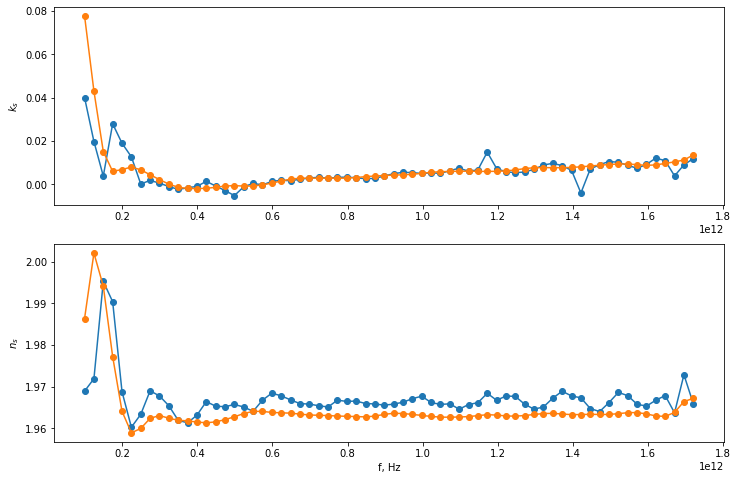

In [24]:
#counts iterative n and k with respect to Fabri-Pero effect (Mira pages 44-45) 
H_model=np.zeros(border_stop, dtype = complex)
epsilon = 0.01
counter = 0
Total_err = 1
control=[]
dzeta_ar = np.arange(0.99,1.01,0.001)
TV_ar = []
TV2_ar = []
dzeta_opt = 0.
TV_min=10000
for dzeta in dzeta_ar:
    for i in range (border_start,border_stop):
        wlc[i] = frequency[i]*2*math.pi*L*dzeta/(3*10**8)
    n_new=np.copy(n_simple)
    k_new=np.copy(k_simple)
    ER_m=np.zeros(border_stop)
    ER_p=np.zeros(border_stop)
    counter = 0
    Total_err = 1
    while (counter < 2000) and (Total_err > epsilon):
        n=np.copy(n_new);   k=np.copy(k_new)
        for i in range (border_start,border_stop):
            n_hat = n[i] - 1.j*k[i]
            H_model[i] = 4*n_hat/(n_hat+1)**2 * cmath.exp(-1.j*(n_hat-1)*wlc[i])
            q = ((1-n_hat)/(n_hat+1))**2 * cmath.exp(-2.j*n_hat*wlc[i])
            H_model[i] = H_model[i] /(1-q)
            ER_p[i] = cmath.phase(H_model[i])
        ER_p = np.unwrap(ER_p)
        for i in range (border_start,border_stop):
            ER_p[i] = ph[i] - ER_p[i]
            ER_m[i] = abs(H[i]) - abs(H_model[i])
            n_new[i] = n[i] - epsilon*ER_p[i]
            k_new[i] = k[i] - epsilon*ER_m[i]
        Total_err = 0
        counter = counter + 1
        for i in range (border_start,border_stop):
            Total_err +=  abs(ER_p[i]) + abs(ER_m[i])
    TV=0; TV2 = 0    
    if (Total_err < epsilon):
        for i in range (border_start,border_stop-1):
            TV += abs(k[i+1]-k[i]) + abs(n[i+1]-n[i])
        for i in range (border_start, border_stop-2):
            TV2 += abs(abs(k[i+2]-k[i+1]) + abs(n[i+2]-n[i+1]) - abs(k[i+1]-k[i]) - abs(n[i+1]-n[i]))
    if TV_min>TV2:
        L_true = dzeta*L
        TV_min=TV2
        n_opt=np.copy(n)
        k_opt=np.copy(k)
        wlc_true = np.copy(wlc)
    
    TV_ar.append(TV)
    TV2_ar.append(TV2)
    percent = (dzeta-dzeta_ar[0])/(dzeta_ar[-1]-dzeta_ar[0])*100
    clear_output(wait=True)
    print("Counted", int(percent),"%")
print("True width is", L_true*10**6, "mkm")
shift = 0
plt.rcParams['figure.figsize'] = [12,8]
fig,a=plt.subplots(2)
#a.plot(dzeta_ar*L*10**6, TV_ar, 'o-')
#a.set_xlabel('$L_s, mkm$')
#a[0].plot(dzeta_ar, TV2_ar, 'o-')
#a.set_ylabel('TV')
a[0].plot(frequency[border_start+shift:border_stop], k_opt[border_start+shift:border_stop], 'o-', label='Mira')
a[0].plot(frequency[border_start+shift:border_stop], k_simple[border_start+shift:border_stop],'o-', label='Simple')
a[0].set_ylabel('$k_s$')
a[1].plot(frequency[border_start+shift:border_stop], n_opt[border_start+shift:border_stop], 'o-', label='Mira')
a[1].plot(frequency[border_start+shift:border_stop], n_simple[border_start+shift:border_stop],'o-', label='Simple')
a[1].set_ylabel('$n_s$')
a[1].set_xlabel('f, Hz')
plt.show()

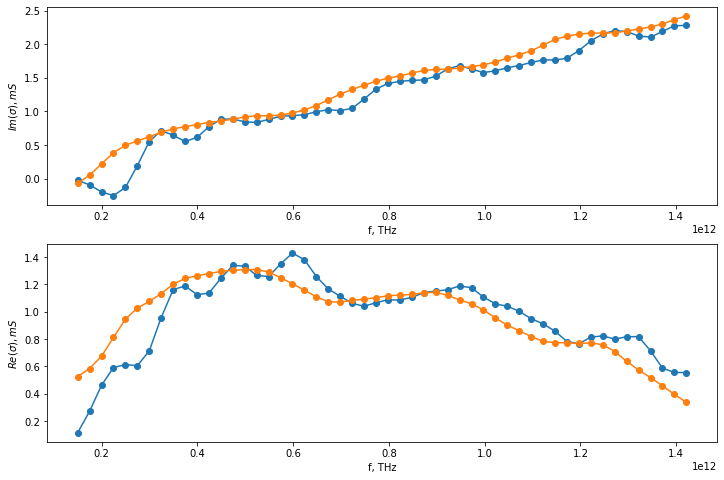

In [28]:
#BRAND NEW! Counts complex conductivity with my method and with thickness allignment
y=np.zeros(border_stop,dtype = complex)
sigma_tinkham=np.zeros(border_stop,dtype = complex)
wlc = np.copy(wlc_true)
for i in range (border_start,border_stop):
    n_hat = n_opt[i] - 1.j*k_opt[i]
    back_relative = signal_w[1,i]/signal_w[2,i]
    y[i] = ((n_hat+1)**2 - (n_hat-1)**2 * cmath.exp(-2.j * n_hat *wlc[i])) * (back_relative-1) / \
        ((n_hat+1)+(n_hat-1) * cmath.exp(-2.j * n_hat *wlc[i]))

for i in range (border_start,border_stop):
    sigma_tinkham[i] = (1+n_simple[i]-1.j*k_simple[i])*(signal_w_gauss[1,i]/signal_w_gauss[2,i]-1)/376

sos = butter(6, int(Long/5), 'lp', fs=Long, output='sos')
y_filter = sosfilt(sos, y)
    

shift = 2
backshift = 12    
plt.rcParams['figure.figsize'] = [12,8]
fig,a=plt.subplots(2)
#a[0].plot(frequency[border_start+shift:border_stop-backshift],y.imag[border_start+shift:border_stop-backshift]*1000/376,'o-')
a[0].plot(frequency[border_start+shift:border_stop-backshift],y_filter.imag[border_start+shift:border_stop-backshift]*1000/376,'o-')
a[0].plot(frequency[border_start+shift:border_stop-backshift], sigma_tinkham.imag[border_start+shift:border_stop-backshift]*1000, 'o-')
a[0].set_ylabel("$Im(\sigma),mS$")
a[0].set_xlabel("f, THz")
#a[1].plot(frequency[border_start+shift:border_stop-backshift],y.real[border_start+shift:border_stop-backshift]*1000/376,'o-', label = 'unfiltered')
a[1].plot(frequency[border_start+shift:border_stop-backshift],y_filter.real[border_start+shift:border_stop-backshift]*1000/376,'o-', label = 'LP_filtere')
a[1].plot(frequency[border_start+shift:border_stop-backshift], sigma_tinkham.real[border_start+shift:border_stop-backshift]*1000, 'o-', label = 'tinkham_gauss')
a[1].set_ylabel("$Re(\sigma),mS$")
a[1].set_xlabel("f, THz")
#a[1].legend(loc='upper right')
y_FP = np.copy(y)

Text(0, 0.5, '$Imag(n)_{optimal}$')

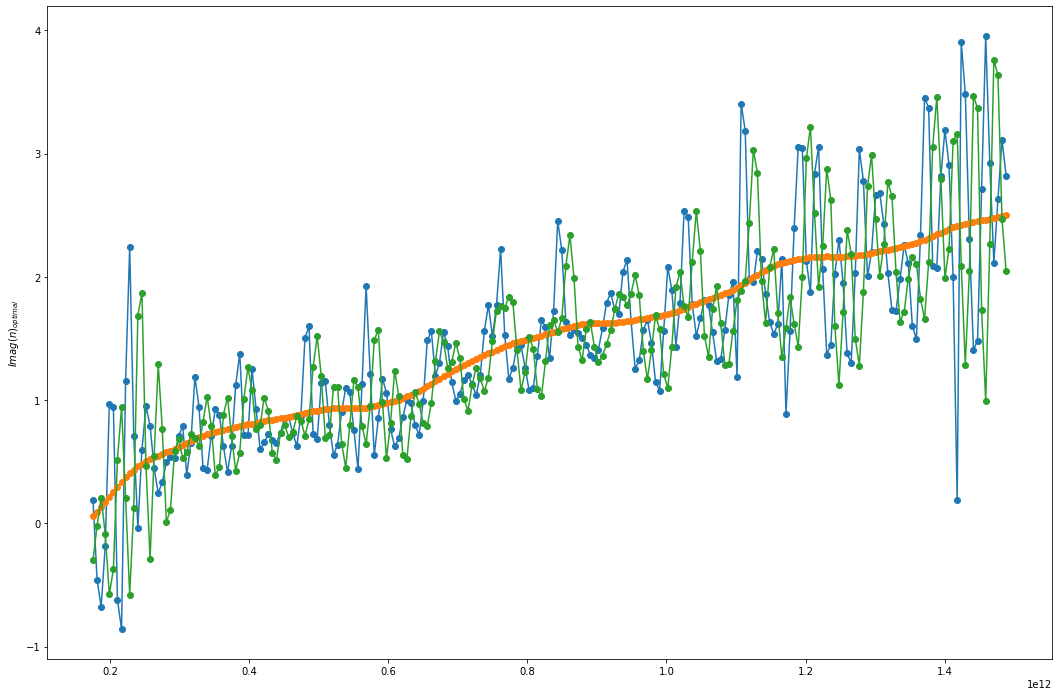

In [170]:
from scipy.signal import butter
from scipy.signal import sosfilt
sos = butter(6, int(Long/4), 'lp', fs=Long, output='sos')
y_filter = sosfilt(sos, y.imag)
fig,a=plt.subplots()
a.plot(frequency[border_start+shift:border_stop-backshift],y.imag[border_start+shift:border_stop-backshift]*1000/376,'o-')
a.plot(frequency[border_start+shift:border_stop-backshift], sigma_tinkham.imag[border_start+shift:border_stop-backshift]*1000, 'o-')
a.plot(frequency[border_start+shift:border_stop-backshift],y_filter[border_start+shift:border_stop-backshift]*1000/376,'o-')
a.set_ylabel('$Imag(n)_{optimal}$')

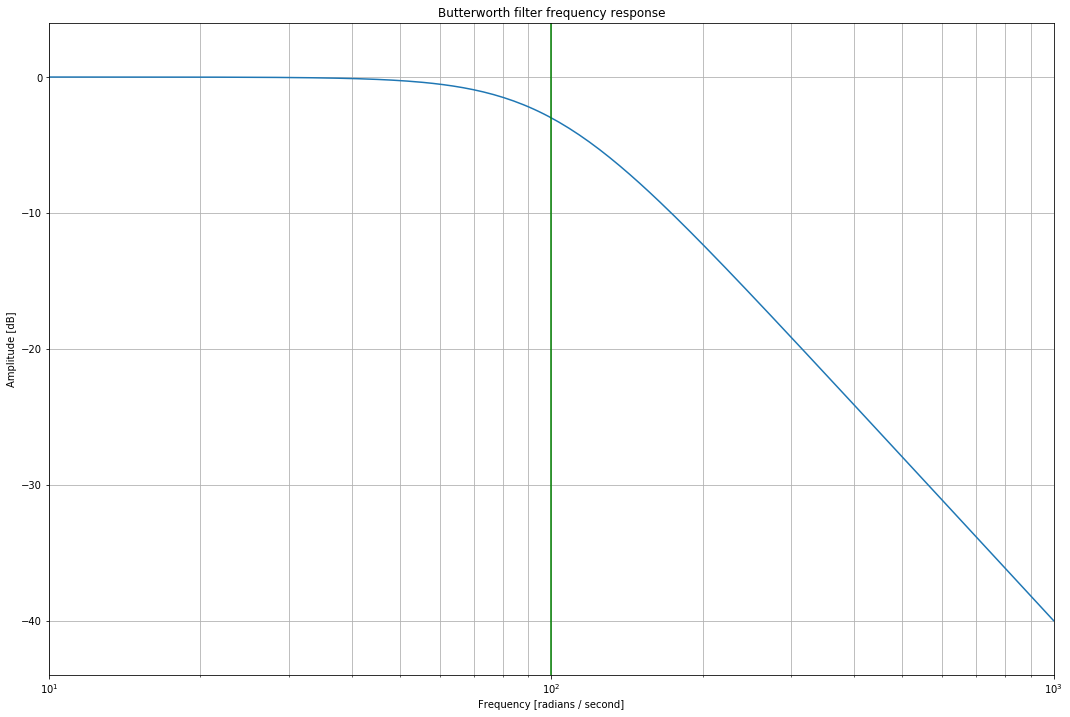

In [134]:
from scipy import signal
import matplotlib.pyplot as plt
b, a = signal.butter(2, 100, 'low', analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

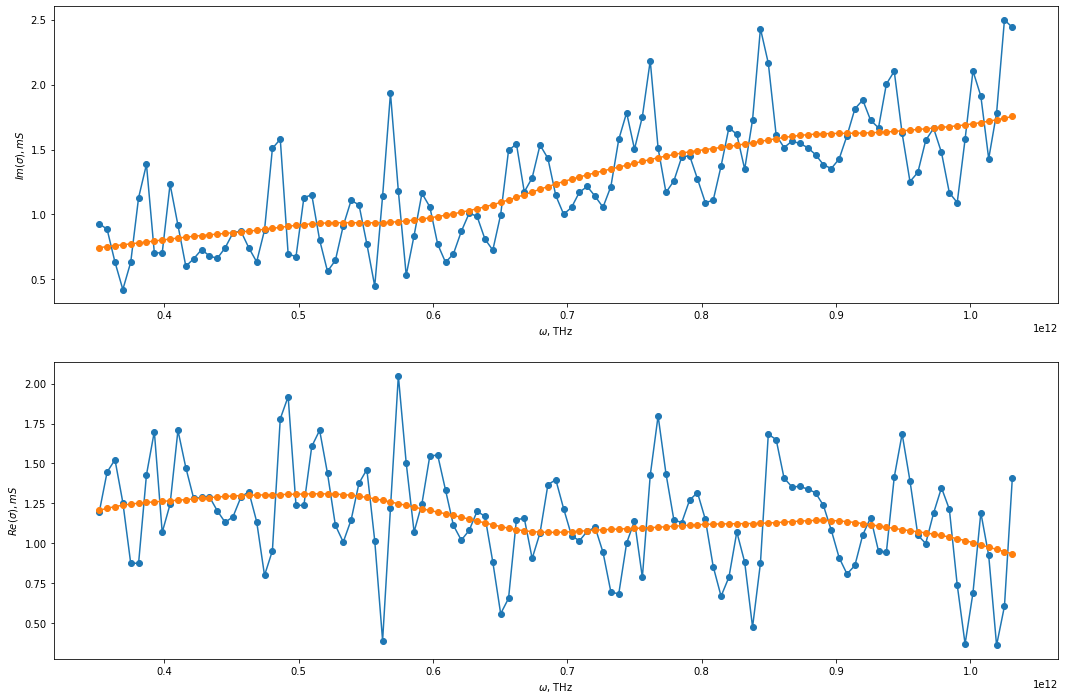

In [386]:
#Counts complex conductivity with my method and with thickness allignment
y=np.zeros(border_stop,dtype = complex)
sigma_tinkham=np.zeros(border_stop,dtype = complex)
wlc = np.copy(wlc_true)
for i in range (border_start,border_stop):
    n_hat = n_opt[i] - 1.j*k_opt[i]
    relative = signal_w[2,i]/signal_w[0,i]
    A = relative*(n_hat-1)/(n_hat+1)*cmath.exp(-2.j*n_hat*wlc[i])
    B = 4*n_hat/(1+n_hat)*cmath.exp(-1.j*wlc[i]*(n_hat-1))
    y[i] = (B-relative-n_hat*relative+n_hat*A-A)/(relative+A)

for i in range (border_start,border_stop):
    sigma_tinkham[i] = (1+n_simple[i]-1.j*k_simple[i])*(signal_w_gauss[1,i]/signal_w_gauss[2,i]-1)/376

shift = 40   
backshift = 103    
plt.rcParams['figure.figsize'] = [18,12]
fig,a=plt.subplots(2)
a[0].plot(frequency[border_start+shift:border_stop-backshift],y.imag[border_start+shift:border_stop-backshift]*1000/376,'o-')
a[0].plot(frequency[border_start+shift:border_stop-backshift], sigma_tinkham.imag[border_start+shift:border_stop-backshift]*1000, 'o-')
a[0].set_ylabel("$Im(\sigma),mS$")
a[0].set_xlabel("$\omega$, THz")
a[1].plot(frequency[border_start+shift:border_stop-backshift],y.real[border_start+shift:border_stop-backshift]*1000/376,'o-')
a[1].plot(frequency[border_start+shift:border_stop-backshift], sigma_tinkham.real[border_start+shift:border_stop-backshift]*1000, 'o-')
a[1].set_ylabel("$Re(\sigma),mS$")
a[1].set_xlabel("$\omega$, THz")
y_FP = np.copy(y)

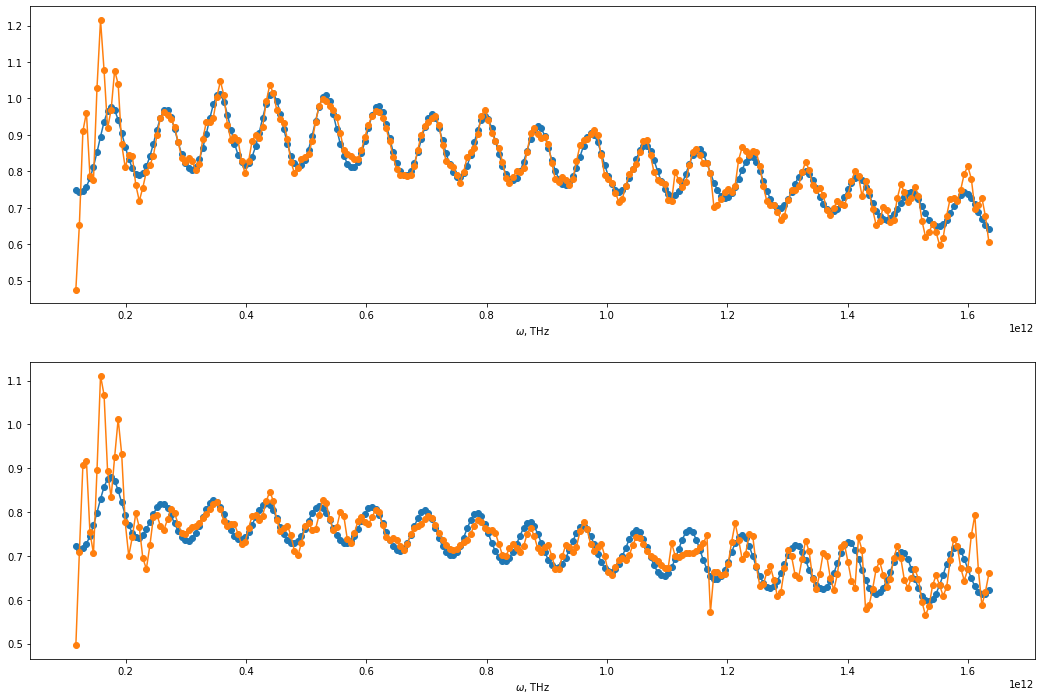

In [7]:
#aDD BLOCK where you compare real measured t_graphene, and calculated with your sigma and n, \
# using two sets of equations: with infinite Fabri-Pero and with some (3-4) FP
#Compare all 3 lines on one graph (!)
E_q_calc = np.zeros(border_stop, dtype = complex)
E_gr_calc = np.zeros(border_stop, dtype = complex)

for i in range (border_start,border_stop):
    n_hat = n_simple[i] - 1.j*k_simple[i]
    t_32 = 2/(n_hat+1)
    t_23 = 2*n_hat/(n_hat+1)
    r_23 = (n_hat-1)/(n_hat+1)
    t_02 = 2/(1+n_hat+sigma_tinkham[i]*376)
    r_20 = (n_hat-1-sigma_tinkham[i]*376)/(n_hat+1+sigma_tinkham[i]*376)
    exp1 = cmath.exp(-1.j * (n_hat-1) * wlc[i])
    exp2 = cmath.exp(-2.j * n_hat * wlc[i])
    E_q_calc[i] = t_32*t_23*exp1 * 1 / (1-r_23**2 * exp2)
    E_gr_calc[i] = t_02*t_23*exp1 * 1 / (1-r_23*r_20*exp2)

fig,a=plt.subplots(2)
a[0].plot(frequency[border_start:border_stop],np.abs(E_q_calc[border_start:border_stop]),'o-')
a[0].plot(frequency[border_start:border_stop],abs(signal_w[1,border_start:border_stop]/signal_w[0,border_start:border_stop]),'o-')
a[0].set_xlabel("$\omega$, THz")
a[1].plot(frequency[border_start:border_stop],np.abs(E_gr_calc[border_start:border_stop]),'o-')
a[1].plot(frequency[border_start:border_stop],abs(signal_w[2,border_start:border_stop]/signal_w[0,border_start:border_stop]),'o-')
a[1].set_xlabel("$\omega$, THz")
plt.show()

In [32]:
#EXPERIMENT FROM 1st JUNE
L = 863/10**6
sd1=100
Long = 1024*2
border_start = 15
border_stop = 128
Double_locker = True
f_name = ["/home/meriff/Python_projects/Experiment_graphene/air_01_06_2020_13_21_05.txt",
        "/home/meriff/Python_projects/Experiment_graphene/sub-quartz_01_06_2020_14_27_50.txt",
        "/home/meriff/Python_projects/Experiment_graphene/Graph_01_06_2020_15_49_34.txt"]

In [34]:
#ALEX QUARTZ EXPERIMENT
L = 863/10**6
Long = 1024*4
border_start = 20
border_stop = 265
Double_locker = True
f_name = ["/home/meriff/Python_projects/Experiment_graphene/air_28_10_2019_13_47_20.txt",
        "/home/meriff/Python_projects/Experiment_graphene/sup_28_10_2019_14_02_22.txt",
        "/home/meriff/Python_projects/Experiment_graphene/Graph_28_10_2019_14_15_00.txt"]

In [12]:
#EXPERIMENT SEPTEMBER (middled)
L = 864/10**6
sd1=350
Long = 1024*4*4
border_start = 5*4
border_stop = 70*4
f_name = ["/home/meriff/Python_projects/Experiment_graphene/air_average.txt",
        "/home/meriff/Python_projects/Experiment_graphene/quartz_average.txt",
        "/home/meriff/Python_projects/Experiment_graphene/graph_average.txt"]

In [30]:
#EXPERIMENT SEPTMBER (multiple samples)
f_name = ["/home/meriff/Python_projects/Experiment_graphene/air_1",
          "/home/meriff/Python_projects/Experiment_graphene/air_2",
          "/home/meriff/Python_projects/Experiment_graphene/air_3",
          "/home/meriff/Python_projects/Experiment_graphene/quartz_1",
          "/home/meriff/Python_projects/Experiment_graphene/quartz_2",
          "/home/meriff/Python_projects/Experiment_graphene/quartz_3",
          "/home/meriff/Python_projects/Experiment_graphene/graph_1",
          "/home/meriff/Python_projects/Experiment_graphene/graph_2",
          "/home/meriff/Python_projects/Experiment_graphene/graph_3"]

timer,signal1,N = read_info(f_name[0])
timer,signal2,N = read_info(f_name[1])
timer,signal3,N = read_info(f_name[2])
for i in range (0,Long):
    signal1[i] = (signal1[i] + signal2[i] + signal3[i])/3
np.savetxt('air_average.txt', np.array([timer,signal1]).T, delimiter='   ')

timer,signal1,N = read_info(f_name[3])
timer,signal2,N = read_info(f_name[4])
timer,signal3,N = read_info(f_name[5])
for i in range (0,Long):
    signal1[i] = (signal1[i] + signal2[i] + signal3[i])/3
np.savetxt('quartz_average.txt', np.array([timer,signal1]).T, delimiter='   ')

timer,signal1,N = read_info(f_name[6])
timer,signal2,N = read_info(f_name[7])
timer,signal3,N = read_info(f_name[8])
for i in range (0,Long):
    signal1[i] = (signal1[i] + signal2[i] + signal3[i])/3
np.savetxt('graph_average.txt', np.array([timer,signal1]).T, delimiter='   ')